## Classification

In [5]:
import seaborn as sns
from matplotlib import dates
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler
import tabulate
warnings.filterwarnings('ignore')
# sns.set(font_scale=5.5)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.5)
df_hrv = pd.read_csv("../data/original/HeartRateVariabilitySDNN.csv")

def parse_date(x):
    return pd.datetime.strptime(x[:-6],'%Y-%m-%d %H:%M:%S')

series = pd.read_csv('../data/original/HeartRateVariabilitySDNN.csv', header=0, index_col=5, parse_dates=[5], squeeze=True, date_parser=parse_date)

df_new = pd.DataFrame()
df_new['value'] = series['value'].resample('H').mean().interpolate()
df_new['creationDate'] = pd.to_datetime(df_new.index)
df_new = df_new.reset_index(drop=True)

df_new['t+1'] = df_new['value'].shift(periods=1)
df_new['t+24'] = df_new['value'].shift(periods=24)
df_new.head()

df_hrv_filtered = df_new

##### 

scaler = StandardScaler()
hrv_merged = pd.DataFrame()

def at_work(row):
#     print(row['creationDate'].hour)
    derp = row['creationDate'].hour
    hour = row['creationDate'].hour
    weekday = row['creationDate'].isoweekday()
    
    if((hour >= 9 and hour <17) and weekday < 6):
        # print(pd.to_datetime(row['creationDate']), (weekday))
        return 1
    return 0
    
# winter is from 1st of November to 1st of April
def is_winter(row):
    month = pd.to_datetime(row['creationDate'], format='%d/%m').month
    
    if(month >= 10 or month < 4):
        return 1
    return 0

def is_higher_than_mean(row):
    mean = 41.25
    if row.value > mean:
        return 1
    return 0

def get_hour_of_day(row):
    hour = pd.to_datetime(row['creationDate']).hour
    return hour

def get_day_of_week(row):
    weekday = pd.to_datetime(row['creationDate']).isoweekday()
    return weekday

def get_time_of_day(row):
    hour = pd.to_datetime(row['creationDate']).hour
    
    if((hour >= 6 and hour <12)):
        return 1
    return 0
    
    
hrv_merged['date'] = df_hrv_filtered['creationDate']
hrv_merged['HRV (SDNN)'] = df_hrv_filtered['value']

work_hours = []
winter_time = []
above_mean = []
hour_of_day = []
day_of_week = []
time_of_day = [] # is morning or afternoon



for (index, row) in df_hrv_filtered.iterrows():

        
    work_hours.append(at_work(row))
#     winter_time.append(is_winter(row))
    above_mean.append(is_higher_than_mean(row))
    hour_of_day.append(get_hour_of_day(row))
    day_of_week.append(get_day_of_week(row))
    time_of_day.append(get_time_of_day(row))
    if (row['value'] > 150):
        df_hrv_filtered.drop(index, inplace=True)
    
hrv_merged['Is at Work (binary)'] = work_hours
hrv_merged['Is Above Mean Value'] = above_mean
hrv_merged['Hour of Day'] = hour_of_day
hrv_merged['Day of Week'] = day_of_week
hrv_merged['Is Morning'] = time_of_day
# hrv_merged['new date'] = hrv_merged['date'].astype(np.int64).values.reshape(-1,1)
hrv_merged['t+1'] = df_hrv_filtered['t+1']

hrv_merged.to_csv('../data/hrv_shaped.csv')

# sns.heatmap(hrv_merged.corr(),
#             vmin=-1,
#             cmap='coolwarm',
#             annot=True);



In [6]:
hrv_merged.head(75)

,date,HRV (SDNN),Is at Work (binary),Is Above Mean Value,Hour of Day,Day of Week,Is Morning,t+1
0,2018-01-16 09:00:00,38.754700,1,0,9,2,1,NaN
1,2018-01-16 10:00:00,36.479380,1,0,10,2,1,38.754700
2,2018-01-16 11:00:00,34.204060,1,0,11,2,1,36.479380
3,2018-01-16 12:00:00,31.928740,1,0,12,2,0,34.204060
4,2018-01-16 13:00:00,29.653420,1,0,13,2,0,31.928740
...,...,...,...,...,...,...,...,...
70,2018-01-19 07:00:00,51.628108,0,1,7,5,1,49.513217
71,2018-01-19 08:00:00,53.743000,0,1,8,5,1,51.628108
72,2018-01-19 09:00:00,53.181989,1,1,9,5,1,53.743000
73,2018-01-19 10:00:00,52.620978,1,1,10,5,1,53.181989


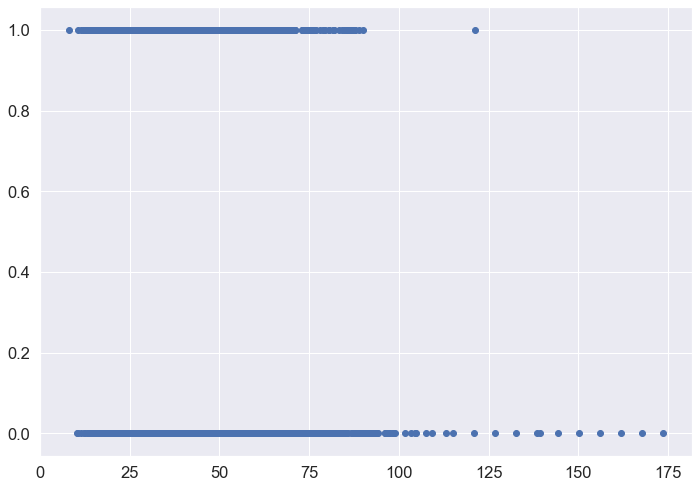

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

X = hrv_merged['HRV (SDNN)'].values.reshape(-1,1)
y = hrv_merged['Is at Work (binary)']

plt.scatter(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [23]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegressionCV

log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

print('coef: {0}'.format(log_reg.coef_))
print('intercept: {0}'.format(log_reg.intercept_))

y_pred = log_reg.predict(X_test)
print('log reg score: {0}'.format(log_reg.score(X_test, y_test)))

y_proba = log_reg.predict_proba(X_test)

print('--------')
print(confusion_matrix(y_test, y_pred))
print('--------')
print(classification_report(y_test,y_pred))

clf = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)

clf.Cs_

# print((2332-683)/2332+683)



coef: [[-0.00076579]]
intercept: [-1.12839074]
log reg score: 0.7628524046434494
--------
[[2300    0]
 [ 715    0]]
--------
              precision    recall  f1-score   support

           0       0.76      1.00      0.87      2300
           1       0.00      0.00      0.00       715

    accuracy                           0.76      3015
   macro avg       0.38      0.50      0.43      3015
weighted avg       0.58      0.76      0.66      3015



array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

[0 0]


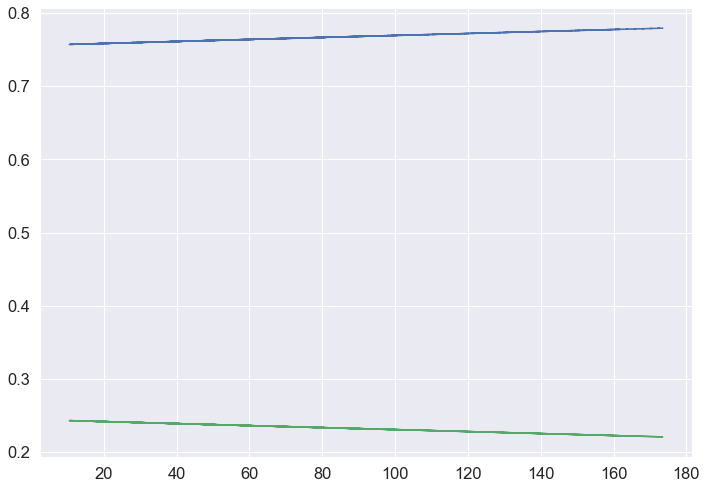

In [13]:
plt.plot(X_test, y_proba[:,1], "g-", label="Is At Work")
plt.plot(X_test, y_proba[:,0], "b--", label="Is Not At Work")

print(log_reg.predict([[43], [125]]))

## Cross validation (baseline, log regression, neural network)

In [61]:
from sklearn import model_selection
import tensorflow as tf
from tensorflow import keras

K=5
outerCV = model_selection.KFold(n_splits=K)
innerCV = model_selection.KFold(n_splits=K)

n_alphas = 10
alphas = np.logspace(-1, 1, n_alphas)
# alphas = range (1, 11, n_alphas)

## errors
min_logreg_regularized_error = 1
min_logreg_alpha = 0

log_reg_inner_error = []
log_reg_min_error = 1
nn_inner_error = []
min_nn_error = 1

## table
table_outer_fold = []

table_baseline_error = []

table_outer_nn_error = []
table_outer_nn_h = []

table_log_reg_error = []
table_log_reg_alpha = []

i=0
for outer_train_index, outer_test_index in outerCV.split(X, y):
    print('Crossvalidation fold: {0}/{1}'.format(i+1,K))
    i+=1
    
    table_outer_fold.append(i)
    min_logreg_regularized_error = 1
    min_logreg_alpha = 0
    
    # Outer folds
    X_train_outer, y_train_outer = X[outer_train_index,:], y[outer_train_index]
    X_test_outer, y_test_outer = X[outer_test_index,:], y[outer_test_index]
    
    ## baseline (log regression) for outer folder
    log_reg = LogisticRegression()
    log_reg.fit(X_train_outer,y_train_outer)
    baseline_error = 1-log_reg.score(X_test_outer, y_test_outer)
    table_baseline_error.append(baseline_error)
    print('Baseline error: {0}'.format(baseline_error))
    
    ## Inner folds
    for inner_train_index, inner_test_index in outerCV.split(X_train_outer):
        X_train_inner, y_train_inner = X[inner_train_index,:], y[inner_train_index]
        X_test_inner, y_test_inner = X[inner_test_index,:], y[inner_test_index]
        
        ### baseline (log regression)
#         log_reg = LogisticRegression()
#         log_reg.fit(X_train_inner,y_train_inner)
    
        ### log regression (shifting lambdas)
        for alpha in alphas:
            log_reg_regularized = LogisticRegression(C=alpha)
            log_reg_regularized.fit(X_train_inner,y_train_inner)
            log_reg_regularized_error = 1-log_reg_regularized.score(X_test_inner, y_test_inner)
            log_reg_inner_error.append({
                'error': log_reg_regularized_error,
                'alpha': alpha
            })
            
        
        for item in log_reg_inner_error:
            if(item['error'] < min_logreg_regularized_error):
                min_logreg_regularized_error = item['error']
            if(item['error'] == min_logreg_regularized_error):
                min_logreg_alpha = item['alpha']
            
        print('logreg error is {0} and min_alpha is {1}'.format(min_logreg_regularized_error, min_logreg_alpha))
        
         
        ### ANN
        for hidden_layer_number in range(1,11):    
            model = keras.models.Sequential([
                keras.layers.Dense(hidden_layer_number, activation="relu", input_shape=X_train_inner.shape[1:]),
                keras.layers.Dense(1)
            ])

            model.compile(loss="mean_squared_error", optimizer="sgd")
            history = model.fit(np.asarray(X_train_inner), np.asarray(y_train_inner), verbose=0)
            mse_test = model.evaluate(np.asarray(X_test_inner), np.asarray(y_test_inner), verbose=0)
            nn_inner_error.append({
                'error': mse_test,
                'h': hidden_layer_number
            })
            
        for item in nn_inner_error:
            if (item['error'] < min_nn_error):
                min_nn_error = item['error']
            if (item['error'] == min_nn_error):
                min_nn_h = item['h']
        
        print('Neural network error is {0} and h is {1}'.format(min_nn_error, min_nn_h))
        
        
    #### NOTE: NEED TO TRAIN IN THE OUTER MODEL WITH THE BEST PARAMETER OF THE INNER MODEL ####
    print('Now start the outer')
    
    ## Logistic Regression regularized
    log_reg_regularized_outer = LogisticRegression(C=min_logreg_alpha)
    log_reg_regularized_outer.fit(X_train_outer,y_train_outer)
    log_reg_regularized_error_outer = 1-log_reg_regularized.score(X_test_outer, y_test_outer)
    table_log_reg_error.append(log_reg_regularized_error_outer)
    table_log_reg_alpha.append(min_logreg_alpha)
    
    ## ANN
    model = keras.models.Sequential([
                keras.layers.Dense(min_nn_h, activation="relu", input_shape=X_train_outer.shape[1:]),
                keras.layers.Dense(1)
            ])
    model.compile(loss="mean_squared_error", optimizer="sgd")
    mse_test = model.evaluate(np.asarray(X_test_outer), np.asarray(y_test_outer), verbose=0)
    table_outer_nn_error.append(mse_test)
    table_outer_nn_h.append(min_nn_h)
    
    
    
        
    



Crossvalidation fold: 1/5
Baseline error: 0.23880597014925375
logreg error is 0.24212271973466004 and min_alpha is 10.0
Neural network error is 0.1835176690696286 and h is 10
logreg error is 0.23548922056384747 and min_alpha is 10.0
Neural network error is 0.1800389566812448 and h is 9
logreg error is 0.23548922056384747 and min_alpha is 10.0
Neural network error is 0.1800389566812448 and h is 9
logreg error is 0.23548922056384747 and min_alpha is 10.0
Neural network error is 0.1800389566812448 and h is 9
logreg error is 0.23548922056384747 and min_alpha is 10.0
Neural network error is 0.1800389566812448 and h is 9
Now start the outer
Crossvalidation fold: 2/5
Baseline error: 0.23814262023217247
logreg error is 0.23548922056384747 and min_alpha is 10.0
Neural network error is 0.1800389566812448 and h is 9
logreg error is 0.23548922056384747 and min_alpha is 10.0
Neural network error is 0.18003435739953919 and h is 2
logreg error is 0.23548922056384747 and min_alpha is 10.0
Neural netwo

In [62]:
print('fold', table_outer_fold)
print('baseline error', table_baseline_error)
print('logistic regression error', table_log_reg_error)
print('lambda', table_log_reg_alpha)
print('nn error', table_outer_nn_error)
print('nn layers', table_outer_nn_h)

fold [1, 2, 3, 4, 5]
baseline error [0.23880597014925375, 0.23814262023217247, 0.23681592039800992, 0.23880597014925375, 0.23888520238885202]
logistic regression error [0.23880597014925375, 0.23814262023217247, 0.23681592039800992, 0.23880597014925375, 0.23888520238885202]
lambda [10.0, 10.0, 10.0, 10.0, 10.0]
nn error [7.162693189428023, 0.23162715101914225, 52.993235181615525, 384.38942028444205, 406.6337513053504]
nn layers [9, 2, 2, 3, 3]


In [63]:
df_final_table = pd.DataFrame()
df_final_table['Outer fold'] = table_outer_fold
df_final_table['Baseline error'] = table_baseline_error
df_final_table['Logistic Regression error'] = table_log_reg_error
df_final_table['λ'] = table_log_reg_alpha
df_final_table['ANN hidden units'] = table_outer_nn_error
df_final_table['ANN error'] = table_outer_nn_h

df_final_table.head()

print(tabulate(df_final_table.head(), tablefmt="pipe", headers="keys"))

|    |   Outer fold |   Baseline error |   Logistic Regression error |   λ |   ANN hidden units |   ANN error |
|---:|-------------:|-----------------:|----------------------------:|----:|-------------------:|------------:|
|  0 |            1 |         0.238806 |                    0.238806 |  10 |           7.16269  |           9 |
|  1 |            2 |         0.238143 |                    0.238143 |  10 |           0.231627 |           2 |
|  2 |            3 |         0.236816 |                    0.236816 |  10 |          52.9932   |           2 |
|  3 |            4 |         0.238806 |                    0.238806 |  10 |         384.389    |           3 |
|  4 |            5 |         0.238885 |                    0.238885 |  10 |         406.634    |           3 |


In [64]:
from scipy import stats
import statsmodels.stats.api as sms

cm1 = sms.CompareMeans(sms.DescrStatsW(table_baseline_error), sms.DescrStatsW(table_log_reg_error))
valcm1 = cm1.tconfint_diff(usevar='unequal')

cm2 = sms.CompareMeans(sms.DescrStatsW(table_baseline_error), sms.DescrStatsW(table_outer_nn_error))
valcm2 = cm2.tconfint_diff(usevar='unequal')

cm3 = sms.CompareMeans(sms.DescrStatsW(table_log_reg_error), sms.DescrStatsW(table_outer_nn_error))
valcm3 = cm3.tconfint_diff(usevar='unequal')

s1, p1 = stats.ttest_rel(table_baseline_error, table_log_reg_error)
s2, p2 = stats.ttest_rel(table_baseline_error, table_outer_nn_error)
s3, p3 = stats.ttest_rel(table_log_reg_error, table_outer_nn_error)

df_comparison = pd.DataFrame()

df_comparison['models'] = ['Baseline VS Log Reg', 'Baseline VS ANN', 'Log Reg VS ANN']
df_comparison['p-value'] = [p1, p2, p3]
df_comparison['confidence interval'] = [valcm1, valcm2, valcm3]

df_comparison.head()





,models,p-value,confidence interval
0,Baseline VS Log Reg,NaN,"(-0.0012800589867520478, 0.0012800589867520478)"
1,Baseline VS ANN,0.13975,"(-426.76057317731534, 86.67286460590034)"
2,Log Reg VS ANN,0.13975,"(-426.76057317731534, 86.67286460590034)"


In [65]:
from tabulate import tabulate

print(tabulate(df_comparison.head(), tablefmt="pipe", headers="keys"))

|    | models              |   p-value | confidence interval                             |
|---:|:--------------------|----------:|:------------------------------------------------|
|  0 | Baseline VS Log Reg | nan       | (-0.0012800589867520478, 0.0012800589867520478) |
|  1 | Baseline VS ANN     |   0.13975 | (-426.76057317731534, 86.67286460590034)        |
|  2 | Log Reg VS ANN      |   0.13975 | (-426.76057317731534, 86.67286460590034)        |
